In [1]:
import socket
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces

class TetrisEnv(gym.Env):
	metadata = {'render_modes': ['human'], 'render_fps': 30}
	action_space = spaces.Discrete(5)
	observation_space = spaces.Box(low=0, high=255, shape=(3, 200, 100), dtype=np.uint8)
	def __init__(self):
		super().__init__()
		self._init()
		self.adress = ('127.0.0.1', 10612)
		self.game = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
		self.game.connect(self.adress)
		
	def _init(self):
		self.move_left_counter = 0
		self.move_right_counter = 0
		self.rotate_counter = 0
		self.block_height = 17

		self.last_holes = 0
		self.last_bumps = 0
		self.last_height = 0
		self.last_removed_lines = 0

		self.life_time = 0
		self.total_reward = 0

	def step(self, action):
		if action == 0:
			self.game.sendall(b'move -1\n')
			self.move_left_counter += 1
		elif action == 1:
			self.game.sendall(b'move 1\n')
			self.move_right_counter += 1
		elif action == 2:
			self.game.sendall(b'rotate 0\n')
			self.rotate_counter += 1
		elif action == 3:
			self.game.sendall(b'rotate 1\n')
			self.rotate_counter += 1
		elif action == 4:
			self.game.sendall(b'drop\n')
		#########################################################################################
		terminated, self.removed_lines, height, holes, self.observation, bump_count, new_block = self._get_info()
		# update values
		if action != 0 or new_block:
			self.move_left_counter = 0
		if action != 1 or new_block:
			self.move_right_counter = 0
		if (action != 2 and action != 3) or new_block:
			self.rotate_counter = 0
		if new_block:
			self.block_height = 17
		else:
			self.block_height -= 1
		#########################################################################################
		# if self.move_left_counter > 7 or self.move_right_counter > 4 or self.rotate_counter > 3:
		# 	terminated = True
		# bonus reward
		if self.block_height > 10:
			reward = (0.2 * (self.block_height - 10) ** 2) * 0.1
		else:
			reward = 0.0

		if new_block:
			# 1
			hole_delta = holes - self.last_holes
			self.last_holes = holes
			reward += (-10 * hole_delta) * 0.1
			# 2
			height_delta = height - self.last_height
			self.last_height = height
			reward += (-5 * height_delta) * 0.1
			# 3
			bump_delta = bump_count - self.last_bumps
			self.last_bumps = bump_count
			if bump_count < 6 and bump_delta > 0:
				bump_delta = 0
			reward += (-2.5 * bump_delta) * 0.1
			# 4
			score_delta = self.removed_lines - self.last_removed_lines
			self.last_removed_lines = self.removed_lines
			reward += 1000 * score_delta * 0.1

		self.life_time += 1
		self.total_reward += reward
		info = {'total_reward': self.total_reward, 'removed_lines': self.removed_lines, 'life_time': self.life_time}
		return (self.observation, reward, terminated, False, info)

	def reset(self):
		self.game.sendall(b'start\n')
		terminated, self.removed_lines, height, holes, self.observation, bump_count, new_block = self._get_info()
		self._init()
		info = {'total_reward': self.total_reward, 'removed_lines': self.removed_lines, 'life_time': self.life_time}
		return self.observation, info
	
	def render(self, pause=True):
		plt.imshow(self.observation)
		if pause == True:
			plt.pause(0.000001)

	def close(self):
		self.game.close()
	
	def _get_info(self):
		is_game_over = (self.game.recv(1) == b'\x01')
		removed_lines = int.from_bytes(self.game.recv(4), 'big')
		height = int.from_bytes(self.game.recv(4), 'big')
		holes = int.from_bytes(self.game.recv(4), 'big')
		img_size = int.from_bytes(self.game.recv(4), 'big')
		img_png = self.game.recv(img_size)

		nparr = np.frombuffer(img_png, np.uint8)
		np_image = cv2.imdecode(nparr, -1)

		gray_image = cv2.cvtColor(np_image, cv2.COLOR_BGR2GRAY)[::10, ::10]
		binary_image = np.where(gray_image > 0, 255, 0)
		# True/False
		new_block = binary_image[0, 6] == 255
		# bump_count
		highest_block_pos = [0] * 10
		bump_count = 0
		for x in range(10):
			col_x = binary_image[20 - height:, x]
			if np.all(col_x == 0):
				highest_block_pos[x] = 0
			else:
				highest_block_pos[x] = height - np.argmax(col_x)
		for i in range(1, 10):
			bump_count += abs(highest_block_pos[i] - highest_block_pos[i-1])
		np_image = np.transpose(np_image, (2, 0, 1))	# (3, 200, 100)

		return is_game_over, removed_lines, height, holes, np_image, bump_count, new_block

In [2]:
import subprocess
subprocess.Popen(['java','-jar','TetrisTCPserver_v0.6.jar'])

<Popen: returncode: None args: ['java', '-jar', 'TetrisTCPserver_v0.6.jar']>

In [3]:
from tqdm import tqdm
import os, shutil
import glob, imageio
import cv2
import numpy as np
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env

NUM_ENV = 100
MODEL_PATH = 'env3_model/best_model.zip'

vec_env = make_vec_env(TetrisEnv, n_envs=NUM_ENV)
obs = vec_env.reset()
model = A2C.load(MODEL_PATH, vec_env, custom_objects = {"observation_space": vec_env.observation_space, "action_space": vec_env.action_space})

replay_folder = './replay'
if os.path.exists(replay_folder):
    shutil.rmtree(replay_folder)

test_steps = 5000
n_env = obs.shape[0]
ep_id = np.zeros(n_env, dtype=int)
cum_reward = np.zeros(n_env)
ep_steps = np.zeros(n_env, dtype=int)
max_reward = 0
max_game_id = 0
max_ep_id = 0
max_rm_lines = 0
max_lifetime = 0

for step in tqdm(range(test_steps)):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
        
    for eID in range(n_env):
        cum_reward[eID] += reward[eID]
        folder = f'{replay_folder}/{str(eID).zfill(4)}/{str(ep_id[eID]).zfill(4)}'
        if not os.path.exists(folder):
            os.makedirs(folder)
        fname = f'{folder}/{str(ep_steps[eID]).zfill(4)}.png'
        cv2.imwrite(fname, np.transpose(obs[eID], (1, 2, 0)))
        ep_steps[eID] += 1
        
        if done[eID]:
            if cum_reward[eID] > max_reward:
                max_reward = cum_reward[eID]
                max_game_id = eID
                max_ep_id = ep_id[eID]
                max_rm_lines = info[eID]['removed_lines']
                max_lifetime = info[eID]['life_time']
                
            ep_id[eID] += 1
            cum_reward[eID] = 0
            ep_steps[eID] = 0

100%|██████████| 5000/5000 [31:26<00:00,  2.65it/s]


In [4]:
best_replay_path = f'{replay_folder}/{str(int(max_game_id)).zfill(4)}/{str(int(max_ep_id)).zfill(4)}'
print(f'After playing 30 envs each for {test_steps} steps:')
print(f'Max reward: {max_reward}, Best video: {best_replay_path}')
print(f'Removed lines: {max_rm_lines}, lifetime: {max_lifetime}')

After playing 30 envs each for 5000 steps:
Max reward: 5993.969996742904, Best video: ./replay/0016/0005
Removed lines: 56, lifetime: 830


In [5]:
filenames = glob.glob(f'{best_replay_path}/*.png')
images = []
for filename in sorted(filenames):
    images.append(imageio.v2.imread(filename))
imageio.mimsave('replay.gif', images, loop=0)

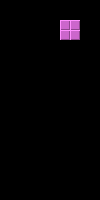

In [6]:
from IPython.display import Image
Image(filename='replay.gif')

In [7]:
if os.path.exists(replay_folder):
    shutil.rmtree(replay_folder)